In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 98% !important }<style>"))

# Analysis

In [2]:
from utilities import *

In [3]:
import joblib
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
ble = read_ble("../Data/ble.csv")
pin = read_pin("../Data/pin.csv")
testPin = read_pin("../Data/testPin.csv")

In [6]:
data = read_data("../Data/rssi_2.csv")
data.shape

All beacons: ['0117C55D14E4']
Selecting all


(63707, 19)

In [7]:
data[scanners] = min_max_scaling(data[scanners])

In [8]:
test = read_data("../Data/testRssi_2.csv")
test.shape

All beacons: ['0117C55D14E4']
Selecting all


(18771, 19)

In [9]:
test[scanners] = min_max_scaling(test[scanners])

## Train Validation Split

In [10]:
train, validation = train_validation_split(data)

In [11]:
train.shape

(50965, 19)

In [12]:
validation.shape

(12742, 19)

In [13]:
train.sort_values("time", inplace=True)
validation.sort_values("time", inplace=True)
test.sort_values("time", inplace=True)

In [14]:
rolling_win = 30
train_rolled = train.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()
validation_rolled = validation.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()
test_rolled = test.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()

In [15]:
train_rolled

,location,level_1,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,E6D9D20DD197,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C
0,V1_10,24997,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,V1_10,24999,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
2,V1_10,25000,0.466667,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
3,V1_10,25001,0.466667,0.400000,NaN,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
4,V1_10,25002,0.483333,0.400000,NaN,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50960,V1_9,31037,0.350000,0.216667,0.316667,0.491667,0.25,NaN,0.275,0.6375,NaN,0.288889,NaN,0.466667,0.383333,0.440000,0.316667,NaN,0.55
50961,V1_9,31039,0.350000,0.238889,0.316667,0.491667,0.25,NaN,0.275,0.6375,NaN,0.288889,NaN,0.466667,0.383333,0.454167,0.300000,NaN,0.55
50962,V1_9,31040,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,NaN,0.288889,NaN,0.466667,0.383333,0.454167,0.266667,NaN,0.55
50963,V1_9,31041,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,NaN,0.308333,NaN,0.466667,0.383333,0.454167,0.283333,NaN,0.55


## Imputation
1. Forward fill

In [16]:
train_imputed = train_rolled.set_index("location").groupby("location").ffill()
train_imputed.reset_index(inplace=True)

In [17]:
train_imputed

,location,level_1,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,E6D9D20DD197,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C
0,V1_10,24997,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,V1_10,24999,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
2,V1_10,25000,0.466667,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
3,V1_10,25001,0.466667,0.400000,NaN,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
4,V1_10,25002,0.483333,0.400000,NaN,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50960,V1_9,31037,0.350000,0.216667,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.288889,0.15,0.466667,0.383333,0.440000,0.316667,0.1,0.55
50961,V1_9,31039,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.288889,0.15,0.466667,0.383333,0.454167,0.300000,0.1,0.55
50962,V1_9,31040,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.288889,0.15,0.466667,0.383333,0.454167,0.266667,0.1,0.55
50963,V1_9,31041,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.308333,0.15,0.466667,0.383333,0.454167,0.283333,0.1,0.55


In [18]:
validation_imputed = validation_rolled.set_index("location").groupby("location").ffill()
validation_imputed.reset_index(inplace=True)

In [19]:
test_imputed = test_rolled.set_index("location").groupby("location").ffill()
test_imputed.reset_index(inplace=True)

In [20]:
train_imputed

,location,level_1,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,E6D9D20DD197,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C
0,V1_10,24997,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,V1_10,24999,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
2,V1_10,25000,0.466667,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
3,V1_10,25001,0.466667,0.400000,NaN,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
4,V1_10,25002,0.483333,0.400000,NaN,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50960,V1_9,31037,0.350000,0.216667,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.288889,0.15,0.466667,0.383333,0.440000,0.316667,0.1,0.55
50961,V1_9,31039,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.288889,0.15,0.466667,0.383333,0.454167,0.300000,0.1,0.55
50962,V1_9,31040,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.288889,0.15,0.466667,0.383333,0.454167,0.266667,0.1,0.55
50963,V1_9,31041,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.308333,0.15,0.466667,0.383333,0.454167,0.283333,0.1,0.55


## Change Location to Coordinates

In [21]:
train_imputed["X"] = train_imputed["location"].apply(lambda x: pin[x]["X"])
train_imputed["Y"] = train_imputed["location"].apply(lambda x: pin[x]["Y"])

In [22]:
validation_imputed["X"] = validation_imputed["location"].apply(lambda x: pin[x]["X"])
validation_imputed["Y"] = validation_imputed["location"].apply(lambda x: pin[x]["Y"])

In [23]:
test_imputed["X"] = test_imputed["location"].apply(lambda x: testPin[x]["X"])
test_imputed["Y"] = test_imputed["location"].apply(lambda x: testPin[x]["Y"])

## Linear Imputation

In [24]:
def linear_impute(data):
    for s in scanners:
        dx = data['X'] - ble[s]['X']
        dy = data['Y'] - ble[s]['Y']
        d = np.sqrt(np.square(dy) + np.square(dx))
        reg = joblib.load('../Models/linear_distance_models_2/{}.joblib'.format(s))
        ss = pd.Series(reg.predict(d.values.reshape((-1, 1))))
        data[s].fillna(ss, inplace=True)

In [25]:
linear_impute(train_imputed)
linear_impute(validation_imputed)
linear_impute(test_imputed)

In [26]:
train_imputed

,location,level_1,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,...,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C,X,Y
0,V1_10,24997,0.466667,0.377514,0.341782,0.571869,0.455598,0.312956,0.270723,0.460916,...,0.335279,0.170158,0.496903,0.577052,0.412474,0.353866,0.070892,0.449889,11.17660,5.29753
1,V1_10,24999,0.466667,0.377514,0.341782,0.571869,0.455598,0.312956,0.270723,0.460916,...,0.335279,0.170158,0.496903,0.666667,0.412474,0.353866,0.070892,0.449889,11.17660,5.29753
2,V1_10,25000,0.466667,0.400000,0.341782,0.571869,0.455598,0.312956,0.270723,0.460916,...,0.335279,0.170158,0.496903,0.666667,0.412474,0.353866,0.070892,0.449889,11.17660,5.29753
3,V1_10,25001,0.466667,0.400000,0.341782,0.566667,0.455598,0.312956,0.270723,0.460916,...,0.335279,0.170158,0.496903,0.666667,0.412474,0.353866,0.070892,0.449889,11.17660,5.29753
4,V1_10,25002,0.483333,0.400000,0.341782,0.566667,0.455598,0.312956,0.270723,0.460916,...,0.335279,0.170158,0.496903,0.666667,0.412474,0.353866,0.070892,0.449889,11.17660,5.29753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50960,V1_9,31037,0.350000,0.216667,0.316667,0.491667,0.250000,0.216667,0.275000,0.637500,...,0.288889,0.150000,0.466667,0.383333,0.440000,0.316667,0.100000,0.550000,8.17867,5.28213
50961,V1_9,31039,0.350000,0.238889,0.316667,0.491667,0.250000,0.216667,0.275000,0.637500,...,0.288889,0.150000,0.466667,0.383333,0.454167,0.300000,0.100000,0.550000,8.17867,5.28213
50962,V1_9,31040,0.350000,0.238889,0.316667,0.491667,0.250000,0.216667,0.275000,0.637500,...,0.288889,0.150000,0.466667,0.383333,0.454167,0.266667,0.100000,0.550000,8.17867,5.28213
50963,V1_9,31041,0.350000,0.238889,0.316667,0.491667,0.250000,0.216667,0.275000,0.637500,...,0.308333,0.150000,0.466667,0.383333,0.454167,0.283333,0.100000,0.550000,8.17867,5.28213


## Model Training

In [27]:
X_train, y_train = train_imputed[scanners].values, train_imputed[["X", "Y"]].values
X_validation, y_validation = validation_imputed[scanners].values, validation_imputed[["X", "Y"]].values
X_test, y_test = test_imputed[scanners].values, test_imputed[["X", "Y"]].values

In [28]:
optimizer = tf.keras.optimizers.Adam(0.00001)
loss = "mse"
metrics = ["mae", "mse"]
batch_size = 32
epochs = 10000

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss')
]

inputs = tf.keras.Input(shape=(17,))
x = tf.keras.layers.Dense(32, activation='relu')(inputs)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dense(8, activation='relu')(x)
x = tf.keras.layers.Dense(1)(x)

y = tf.keras.layers.Dense(32, activation='relu')(inputs)
y = tf.keras.layers.Dense(16, activation='relu')(y)
y = tf.keras.layers.Dense(8, activation='relu')(y)
y = tf.keras.layers.Dense(1)(y)

outputs = tf.keras.layers.Concatenate(axis=1)([x, y])

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           576         input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 32)           576         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           528         dense[0][0]                      
______________________________________________________________________________________________

In [30]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Train on 50965 samples, validate on 18771 samples
Epoch 1/10000
50965/50965 [==============================] - 3s 53us/sample - loss: 206.2112 - mae: 12.4099 - mse: 206.2111 - val_loss: 212.0920 - val_mae: 12.7474 - val_mse: 212.0921
Epoch 2/10000
50965/50965 [==============================] - 2s 38us/sample - loss: 193.2167 - mae: 11.8409 - mse: 193.2167 - val_loss: 195.2083 - val_mae: 12.0478 - val_mse: 195.2083
Epoch 3/10000
50965/50965 [==============================] - 2s 38us/sample - loss: 173.1829 - mae: 10.9408 - mse: 173.1829 - val_loss: 170.8540 - val_mae: 10.9788 - val_mse: 170.8540
Epoch 4/10000
50965/50965 [==============================] - 2s 38us/sample - loss: 145.5698 - mae: 9.5988 - mse: 145.5698 - val_loss: 137.5682 - val_mae: 9.3959 - val_mse: 137.5682
Epoch 5/10000
50965/50965 [==============================] - 2s 38us/sample - loss: 110.1039 - mae: 7.7533 - mse: 110.1038 - val_loss: 98.5172 - val_mae: 7.4647 - val_mse: 98.5172
Epoch 6/10000
50965/50965 [=========

50965/50965 [==============================] - 2s 38us/sample - loss: 1.6363 - mae: 0.9980 - mse: 1.6363 - val_loss: 3.0694 - val_mae: 1.4374 - val_mse: 3.0694
Epoch 48/10000
50965/50965 [==============================] - 2s 38us/sample - loss: 1.6276 - mae: 0.9950 - mse: 1.6276 - val_loss: 3.0728 - val_mae: 1.4378 - val_mse: 3.0728
Epoch 49/10000
50965/50965 [==============================] - 2s 38us/sample - loss: 1.6194 - mae: 0.9919 - mse: 1.6194 - val_loss: 3.0623 - val_mae: 1.4361 - val_mse: 3.0623
Epoch 50/10000
50965/50965 [==============================] - 2s 38us/sample - loss: 1.6118 - mae: 0.9892 - mse: 1.6118 - val_loss: 3.0626 - val_mae: 1.4370 - val_mse: 3.0626
Epoch 51/10000
50965/50965 [==============================] - 2s 38us/sample - loss: 1.6042 - mae: 0.9863 - mse: 1.6042 - val_loss: 3.0562 - val_mae: 1.4336 - val_mse: 3.0562
Epoch 52/10000
50965/50965 [==============================] - 2s 38us/sample - loss: 1.5969 - mae: 0.9836 - mse: 1.5969 - val_loss: 3.0466 -

Epoch 94/10000
50965/50965 [==============================] - 2s 38us/sample - loss: 1.3475 - mae: 0.8900 - mse: 1.3475 - val_loss: 2.8450 - val_mae: 1.3790 - val_mse: 2.8450
Epoch 95/10000
50965/50965 [==============================] - 2s 38us/sample - loss: 1.3422 - mae: 0.8880 - mse: 1.3422 - val_loss: 2.8478 - val_mae: 1.3844 - val_mse: 2.8478
Epoch 96/10000
50965/50965 [==============================] - 2s 38us/sample - loss: 1.3370 - mae: 0.8857 - mse: 1.3370 - val_loss: 2.8317 - val_mae: 1.3764 - val_mse: 2.8317
Epoch 97/10000
50965/50965 [==============================] - 2s 38us/sample - loss: 1.3314 - mae: 0.8836 - mse: 1.3314 - val_loss: 2.8333 - val_mae: 1.3762 - val_mse: 2.8333
Epoch 98/10000
50965/50965 [==============================] - 2s 36us/sample - loss: 1.3261 - mae: 0.8816 - mse: 1.3261 - val_loss: 2.8215 - val_mae: 1.3739 - val_mse: 2.8215
Epoch 99/10000
50965/50965 [==============================] - 2s 36us/sample - loss: 1.3209 - mae: 0.8796 - mse: 1.3209 - val

50965/50965 [==============================] - 2s 33us/sample - loss: 1.0782 - mae: 0.7828 - mse: 1.0782 - val_loss: 2.5957 - val_mae: 1.3030 - val_mse: 2.5957
Epoch 141/10000
50965/50965 [==============================] - 2s 33us/sample - loss: 1.0728 - mae: 0.7805 - mse: 1.0728 - val_loss: 2.5911 - val_mae: 1.3028 - val_mse: 2.5911
Epoch 142/10000
50965/50965 [==============================] - 2s 33us/sample - loss: 1.0671 - mae: 0.7782 - mse: 1.0671 - val_loss: 2.5900 - val_mae: 1.3043 - val_mse: 2.5900
Epoch 143/10000
50965/50965 [==============================] - 2s 33us/sample - loss: 1.0616 - mae: 0.7759 - mse: 1.0616 - val_loss: 2.5846 - val_mae: 1.3011 - val_mse: 2.5846
Epoch 144/10000
50965/50965 [==============================] - 2s 33us/sample - loss: 1.0560 - mae: 0.7735 - mse: 1.0560 - val_loss: 2.5815 - val_mae: 1.3009 - val_mse: 2.5814
Epoch 145/10000
50965/50965 [==============================] - 2s 33us/sample - loss: 1.0506 - mae: 0.7713 - mse: 1.0506 - val_loss: 2.5

50965/50965 [==============================] - 2s 35us/sample - loss: 0.8532 - mae: 0.6851 - mse: 0.8532 - val_loss: 2.4530 - val_mae: 1.2440 - val_mse: 2.4530
Epoch 187/10000
50965/50965 [==============================] - 2s 32us/sample - loss: 0.8490 - mae: 0.6832 - mse: 0.8490 - val_loss: 2.4540 - val_mae: 1.2419 - val_mse: 2.4540
Epoch 188/10000
50965/50965 [==============================] - 2s 32us/sample - loss: 0.8453 - mae: 0.6815 - mse: 0.8453 - val_loss: 2.4533 - val_mae: 1.2414 - val_mse: 2.4533
Epoch 189/10000
50965/50965 [==============================] - 2s 38us/sample - loss: 0.8412 - mae: 0.6796 - mse: 0.8412 - val_loss: 2.4457 - val_mae: 1.2424 - val_mse: 2.4457
Epoch 190/10000
50965/50965 [==============================] - 2s 39us/sample - loss: 0.8373 - mae: 0.6778 - mse: 0.8373 - val_loss: 2.4498 - val_mae: 1.2384 - val_mse: 2.4498
Epoch 191/10000
50965/50965 [==============================] - 2s 36us/sample - loss: 0.8333 - mae: 0.6759 - mse: 0.8333 - val_loss: 2.4

50965/50965 [==============================] - 2s 33us/sample - loss: 0.7027 - mae: 0.6137 - mse: 0.7027 - val_loss: 2.4145 - val_mae: 1.2203 - val_mse: 2.4145
Epoch 233/10000
50965/50965 [==============================] - 2s 32us/sample - loss: 0.7001 - mae: 0.6123 - mse: 0.7001 - val_loss: 2.4141 - val_mae: 1.2207 - val_mse: 2.4141
Epoch 234/10000
50965/50965 [==============================] - 2s 33us/sample - loss: 0.6974 - mae: 0.6111 - mse: 0.6974 - val_loss: 2.4125 - val_mae: 1.2189 - val_mse: 2.4125
Epoch 235/10000
50965/50965 [==============================] - 2s 36us/sample - loss: 0.6950 - mae: 0.6099 - mse: 0.6950 - val_loss: 2.4188 - val_mae: 1.2199 - val_mse: 2.4188
Epoch 236/10000
50965/50965 [==============================] - 2s 36us/sample - loss: 0.6923 - mae: 0.6087 - mse: 0.6923 - val_loss: 2.4174 - val_mae: 1.2201 - val_mse: 2.4174
Epoch 237/10000
50965/50965 [==============================] - 2s 39us/sample - loss: 0.6898 - mae: 0.6073 - mse: 0.6898 - val_loss: 2.4

50965/50965 [==============================] - 2s 38us/sample - loss: 0.5969 - mae: 0.5635 - mse: 0.5969 - val_loss: 2.4319 - val_mae: 1.2185 - val_mse: 2.4319
Epoch 279/10000
50965/50965 [==============================] - 2s 38us/sample - loss: 0.5948 - mae: 0.5627 - mse: 0.5948 - val_loss: 2.4314 - val_mae: 1.2198 - val_mse: 2.4314


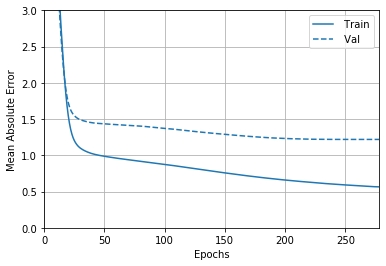

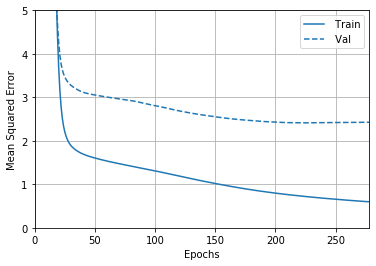

In [31]:
plt.figure()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({"": history}, metric = "mae")
plt.ylim([0, 3])
plt.ylabel('Mean Absolute Error')

plt.figure()
plotter.plot({"": history}, metric = "mse")
plt.ylim([0, 5])
plt.ylabel('Mean Squared Error')

plt.show()

## Model Validation

In [32]:
def inv_scale(y):
    ret_y = np.copy(y)
    ret_y[:, 0] = ret_y[:, 0] * 33.5
    ret_y[:, 1] = ret_y[:, 1] * 16.8
    return ret_y

def average_distance_error(preds, y_test, scaled=False):
    if scaled:
        preds = inv_scale(preds)
        y_test = inv_scale(y_test)
    return np.mean(np.sqrt(np.sum(np.square(preds - y_test), axis=1)))

12742/1 - 0s - loss: 0.3495 - mae: 0.5728 - mse: 0.6006
Validation loss: 0.6005902018949443
Mean absolute error: 0.57276523
Mean squared error: 0.6005903
Average distance error: 0.9250513649415186


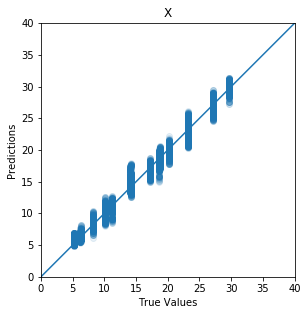

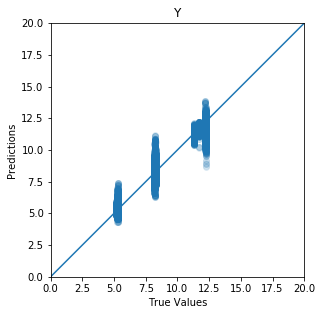

In [33]:
validation_scores = model.evaluate(X_validation, y_validation, verbose=2)
print("Validation loss:", validation_scores[0])
print("Mean absolute error:", validation_scores[1])
print("Mean squared error:", validation_scores[2])

preds = model.predict(X_validation)
print("Average distance error:", average_distance_error(preds, y_validation))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, 0], preds[:, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, 1], preds[:, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

## Model Testing

18771/1 - 0s - loss: 2.0408 - mae: 1.2198 - mse: 2.4314
Test loss: 2.4313820209940613
Mean absolute error: 1.2198237
Mean squared error: 2.4313846
Average distance error: 1.9553906376643384


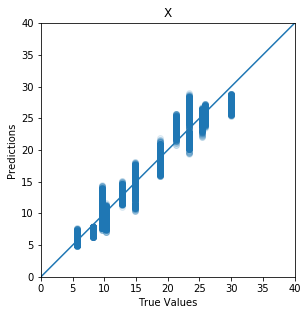

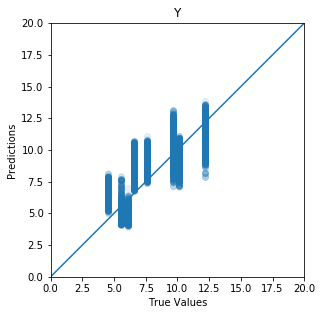

In [34]:
test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Mean absolute error:", test_scores[1])
print("Mean squared error:", test_scores[2])

preds = model.predict(X_test)
print("Average distance error:", average_distance_error(preds, y_test))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_test[:, 0], preds[:, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')

ax1.scatter(y_test[:, 1], preds[:, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

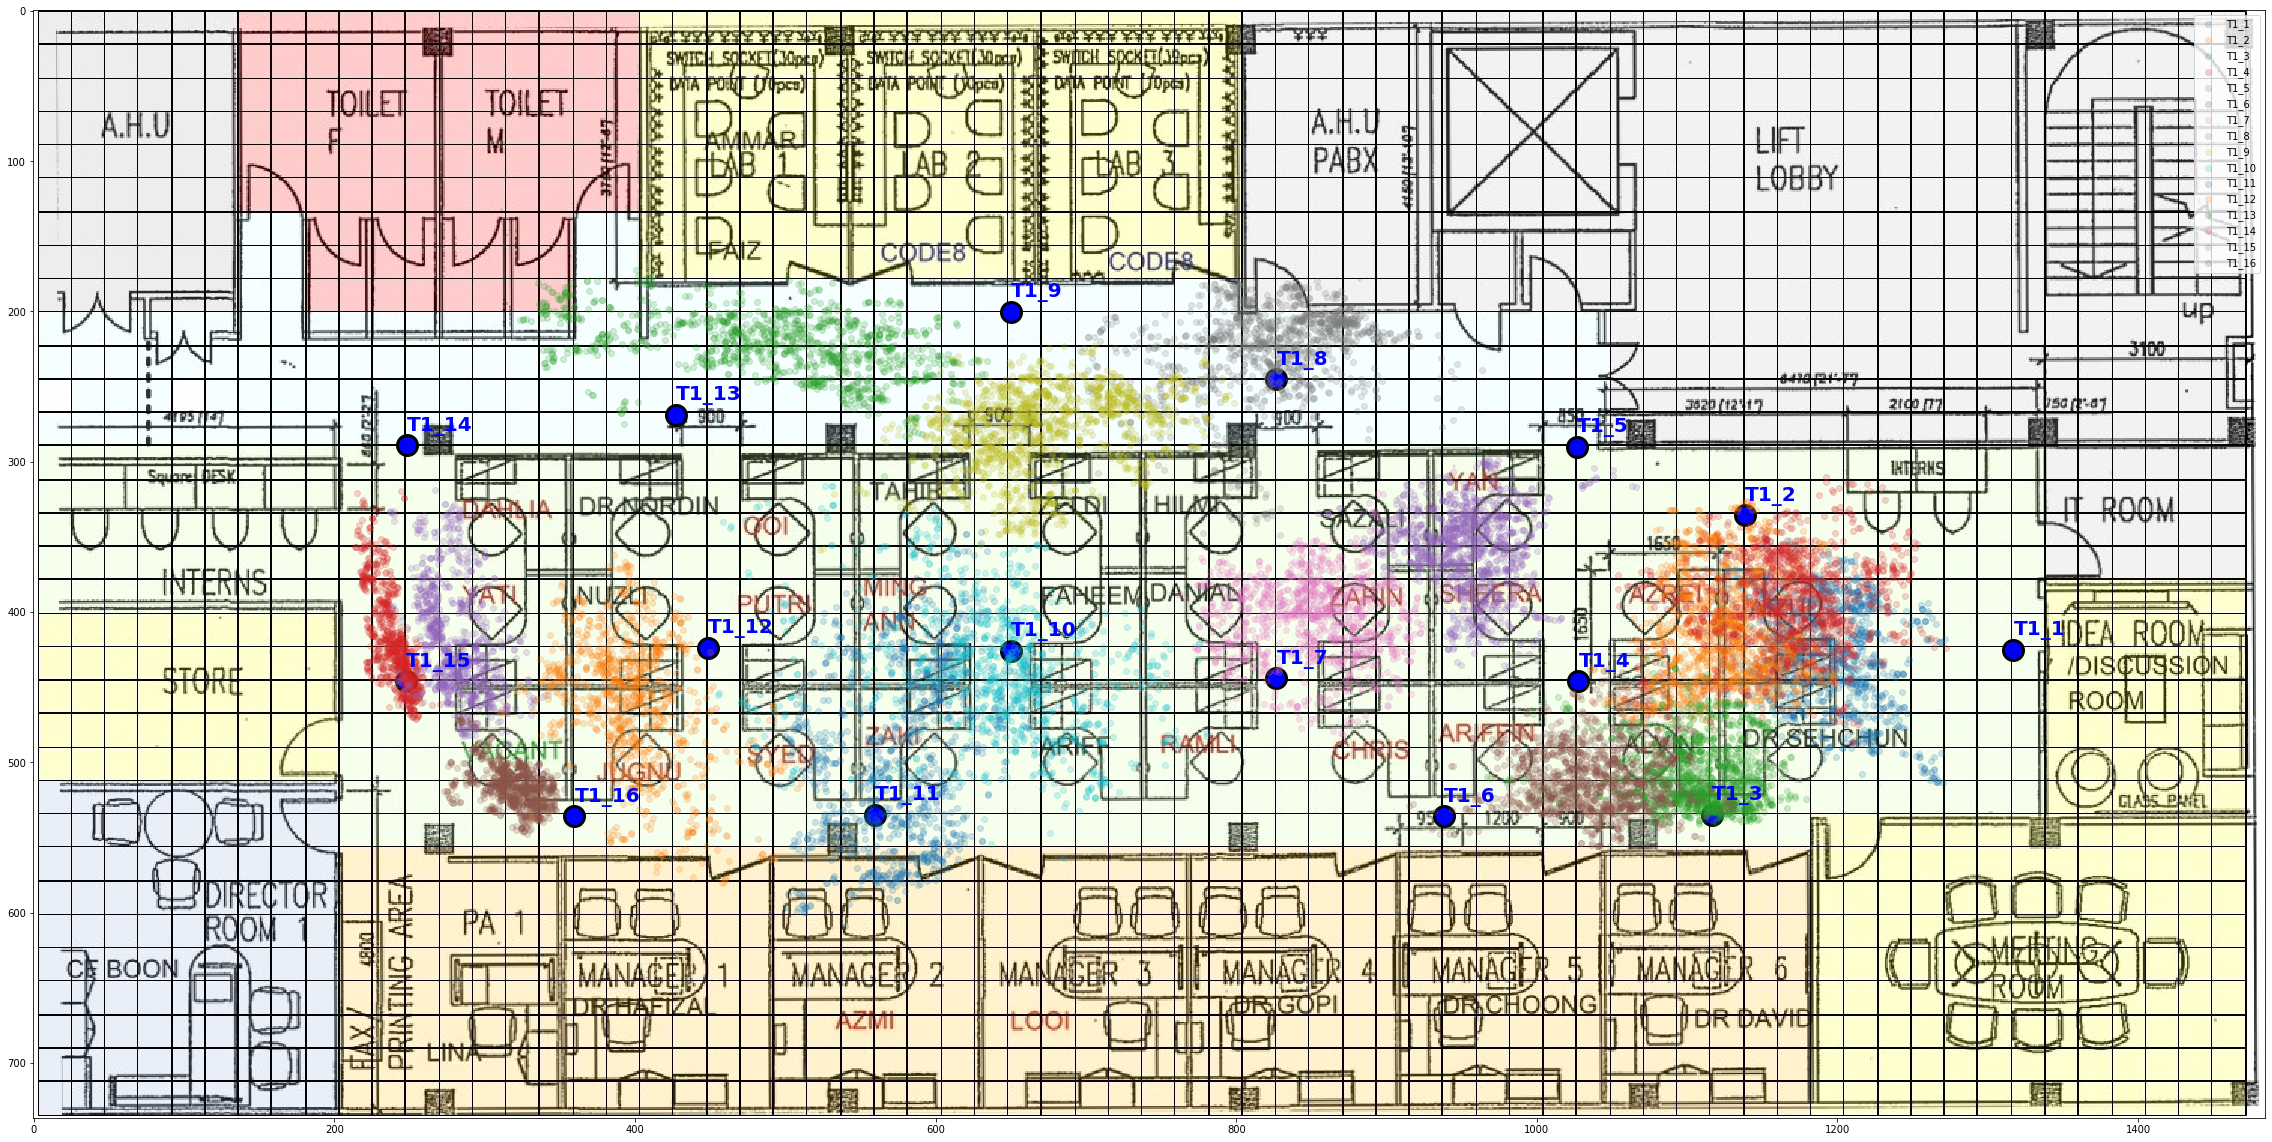

In [35]:
img =  mpimg.imread('../Map/main.png')
fingerprint_color = "r"
testdata_color = "b"
plt.figure(figsize=(40,40))
plt.imshow(img)

labels = ["V1_23", "V1_24", "V1_32", "V1_22", "V1_14", "V1_13", "V1_12", "V1_21", "V1_29", "V1_30", "V1_31", "V1_11", "V1_20", "V1_28", "V1_10", "V1_19", "V1_27", "V1_9", "V1_8", "V1_18", "V1_26"]
x = [27.151600, 29.594400, 29.689400, 23.153700, 23.169100, 20.171700, 17.173201, 18.712299, 18.691700, 23.244200, 27.133301, 14.063600, 14.159800, 14.250300, 11.176600, 10.162500, 10.141900, 8.178670, 5.180690, 6.164600, 6.255650]
y = [8.159480, 8.172020, 11.286000, 8.250140, 5.247920, 5.121330, 5.217130, 8.227330, 12.230300, 12.253700, 11.717700, 5.312350, 8.203950, 12.207500, 5.297530, 8.183420, 12.186400, 5.282130, 5.266730, 8.274090, 12.166400]
x = np.array(x) * 44
y = np.array(y) * 44

testLabels = ["T1_1", "T1_2", "T1_3", "T1_4", "T1_5", "T1_6", "T1_7", "T1_8", "T1_9", "T1_10", "T1_11", "T1_12", "T1_13", "T1_14", "T1_15", "T1_16"]
testX = [29.934250, 25.877805, 25.372470, 23.355726, 23.333564, 21.316819, 18.790348, 18.790348, 14.779021, 14.779021, 12.717952, 10.191480, 9.703916, 5.648265, 5.626103, 8.174736]
testY = [9.659024, 7.630801, 12.155781, 10.139037, 6.593112, 12.177943, 10.094712, 5.573659, 4.554205, 9.673634, 12.155781, 9.629310, 6.105547, 6.570950, 10.139037, 12.177943]
testX = np.array(testX) * 44
testY = np.array(testY) * 44

# plt.scatter(x, y, s=400, c=fingerprint_color, edgecolors="black", linewidths=3)
plt.scatter(testX, testY, s=400, c=testdata_color, edgecolors="black", linewidths=3)

# for i in range(len(labels)):
#     plt.annotate(labels[i], (x[i], y[i] - 10), fontsize=20, color=fingerprint_color, weight='bold')

for j in range(len(testLabels)):
    plt.annotate(testLabels[j], (testX[j], testY[j] - 10), fontsize=20, color=testdata_color, weight='bold')

for i in range(len(testLabels)):
    loc = testLabels[i]
    test_loc = test_imputed[test_imputed['location'] == loc]
    X_loc = test_loc[scanners].values
    locs = model.predict(X_loc) * 44
    plt.scatter(locs[:, 0], locs[:, 1], alpha=0.2, label=testLabels[i])
plt.legend()

In [ ]:
validation_error = []
test_error = []

for i in [10, 30, 50, 100]:
    
    print()
    print('=' * 20)
    print('Rolling Window: {}'.format(i))
    print('=' * 20)
    print()
    
    data = read_data("../Data/rssi_2.csv")
    data[scanners] = min_max_scaling(data[scanners])

    test = read_data("../Data/testRssi_2.csv")
    test[scanners] = min_max_scaling(test[scanners])

    ## Train Validation Split

    train, validation = train_validation_split(data)
    train.sort_values("time", inplace=True)
    validation.sort_values("time", inplace=True)
    test.sort_values("time", inplace=True)

    rolling_win = i
    train_rolled = train.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()
    validation_rolled = validation.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()
    test_rolled = test.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()

    ## Imputation
    
    train_imputed = train_rolled.set_index("location").groupby("location").ffill()
    train_imputed.reset_index(inplace=True)
    
    validation_imputed = validation_rolled.set_index("location").groupby("location").ffill()
    validation_imputed.reset_index(inplace=True)

    test_imputed = test_rolled.set_index("location").groupby("location").ffill()
    test_imputed.reset_index(inplace=True)

    ## Change Location to Coordinates

    train_imputed["X"] = train_imputed["location"].apply(lambda x: pin[x]["X"])
    train_imputed["Y"] = train_imputed["location"].apply(lambda x: pin[x]["Y"])

    validation_imputed["X"] = validation_imputed["location"].apply(lambda x: pin[x]["X"])
    validation_imputed["Y"] = validation_imputed["location"].apply(lambda x: pin[x]["Y"])

    test_imputed["X"] = test_imputed["location"].apply(lambda x: testPin[x]["X"])
    test_imputed["Y"] = test_imputed["location"].apply(lambda x: testPin[x]["Y"])

    ## Linear Imputation

    linear_impute(train_imputed)
    linear_impute(validation_imputed)
    linear_impute(test_imputed)

    ## Model Training

    X_train, y_train = train_imputed[scanners].values, train_imputed[["X", "Y"]].values
    X_validation, y_validation = validation_imputed[scanners].values, validation_imputed[["X", "Y"]].values
    X_test, y_test = test_imputed[scanners].values, test_imputed[["X", "Y"]].values
    
    ## Create Model
    
    optimizer = tf.keras.optimizers.Adam(0.00001)
    loss = "mse"
    metrics = ["mae", "mse"]
    batch_size = 32
    epochs = 10000

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss')
    ]

    inputs = tf.keras.Input(shape=(17,))
    x = tf.keras.layers.Dense(16, activation='relu')(inputs)
    x = tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

    y = tf.keras.layers.Dense(16, activation='relu')(inputs)
    y = tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)
    y = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)

    outputs = tf.keras.layers.Concatenate(axis=1)([x, y])

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

    plt.figure()
    plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
    plotter.plot({"": history}, metric = "mae")
    plt.ylim([0, 3])
    plt.ylabel('Mean Absolute Error')

    plt.figure()
    plotter.plot({"": history}, metric = "mse")
    plt.ylim([0, 5])
    plt.ylabel('Mean Squared Error')
    
    plt.show()

    ## Model Validation

    validation_scores = model.evaluate(X_validation, y_validation, verbose=2)
    print("Validation loss:", validation_scores[0])
    print("Mean absolute error:", validation_scores[1])
    print("Mean squared error:", validation_scores[2])

    preds = model.predict(X_validation)
    validation_avg_derror = average_distance_error(preds, y_validation)
    print("Average distance error:", validation_avg_derror)
        
    validation_error.append((validation_scores[2], validation_avg_derror))

    fig = plt.figure(figsize=(10, 20))
    lims = [0, 40]
    ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
    ax1.scatter(y_validation[:, 0], preds[:, 0], alpha=0.1)
    ax1.plot(lims, lims)

    fig = plt.figure(figsize=(10, 20))
    lims = [0, 20]
    ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
    ax1.scatter(y_validation[:, 1], preds[:, 1], alpha=0.1)
    ax1.plot(lims, lims)

    plt.show()
    print()
    
    ## Model Testing

    test_scores = model.evaluate(X_test, y_test, verbose=2)
    print("Test loss:", test_scores[0])
    print("Mean absolute error:", test_scores[1])
    print("Mean squared error:", test_scores[2])

    preds = model.predict(X_test)
    test_avg_derror = average_distance_error(preds, y_test)
    print("Average distance error:", test_avg_derror)
    
    test_error.append((test_scores[2], test_avg_derror))

    fig = plt.figure(figsize=(10, 20))
    lims = [0, 40]
    ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
    ax1.scatter(y_test[:, 0], preds[:, 0], alpha=0.1)
    ax1.plot(lims, lims)

    fig = plt.figure(figsize=(10, 20))
    lims = [0, 20]
    ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')

    ax1.scatter(y_test[:, 1], preds[:, 1], alpha=0.1)
    ax1.plot(lims, lims)

    plt.show()


Rolling Window: 10

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all
Train on 50965 samples, validate on 18771 samples
Epoch 1/10000
50965/50965 [==============================] - 2s 46us/sample - loss: 205.7670 - mae: 12.2782 - mse: 205.7422 - val_loss: 213.8508 - val_mae: 12.6784 - val_mse: 213.8265
Epoch 2/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 198.8556 - mae: 11.8637 - mse: 198.8313 - val_loss: 205.6386 - val_mae: 12.2204 - val_mse: 205.6148
Epoch 3/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 190.9705 - mae: 11.3838 - mse: 190.9467 - val_loss: 197.2759 - val_mae: 11.7383 - val_mse: 197.2523
Epoch 4/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 182.6818 - mae: 10.8651 - mse: 182.6584 - val_loss: 188.2444 - val_mae: 11.2082 - val_mse: 188.2210
Epoch 5/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 173.8783 - mae: 10.29